In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
import sys
import time
warnings.filterwarnings('ignore')

from tqdm import tqdm
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [2]:
try:
    import google.colab
    from google.colab import drive
    !uv pip install anomalib
    !uv pip install open-clip-torch
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path('/content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation') # 본인 경로 수정: Mac/Window
except ImportError:
    PROJECT_ROOT = Path.cwd().parents[1]

os.chdir(PROJECT_ROOT) # 현재 경로 수정
print(f"Current working directory: {os.getcwd()}")

Using Python 3.12.12 environment at: /usr
Resolved 94 packages in 1.68s
Prepared 12 packages in 671ms
Installed 12 packages in 23ms
 + anomalib==2.2.0
 + freia==0.2
 + imagecodecs==2026.1.14
 + jsonargparse==4.46.0
 + kornia==0.8.2
 + kornia-rs==0.1.10
 + lightning==2.6.1
 + lightning-utilities==0.15.2
 + pytorch-lightning==2.6.1
 + rich-argparse==1.7.2
 + torchmetrics==1.8.2
 + typeshed-client==2.8.2
Using Python 3.12.12 environment at: /usr
Resolved 49 packages in 101ms
Prepared 2 packages in 56ms
Installed 2 packages in 7ms
 + ftfy==6.3.1
 + open-clip-torch==3.2.0
Mounted at /content/drive
Current working directory: /content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation


In [3]:
# TODO: PATH 설정

# dataset path
DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"
DOMAIN_JSON = DATA_ROOT / "domain_knowledge.json"
MMAD_JSON = DATA_ROOT / "mmad.json"
META_CSV = DATA_ROOT / "metadata.csv"

# config.yaml path
CONFIG_ROOT = PROJECT_ROOT / "configs"
RUNTIME_CONFIG_ROOT = CONFIG_ROOT / "runtime.yaml"
EVAL_CONFIG_ROOT = CONFIG_ROOT / "eval.yaml"

# output path
OUTPUT_ROOT = PROJECT_ROOT / "output"

# check (선택사항)
# print(f"Project Root: {PROJECT_ROOT}")
# print(f"Data Root: {DATA_ROOT}")
# print(f"Config Root: {CONFIG_ROOT}")

### MVTecAD Dataset

In [4]:
from src.utils import load_config, load_json, load_csv
from anomalib.data import MVTecAD
from anomalib.models import EfficientAd
from anomalib.engine import Engine

# TODO: runtime_config.yaml 확장/수정
runtime_config = load_config(RUNTIME_CONFIG_ROOT)
domain_json = load_json(DOMAIN_JSON)
mmad_json = load_json(MMAD_JSON)
meta_csv = load_csv(META_CSV)

# tqdm bar off
os.environ["TQDM_DISABLE"] = "1"
categories = [
    "bottle", "grid", "pill", "toothbrush"
]

In [5]:
# Train the model
for i, category in enumerate(categories, 1):
    print(f"\n[{i}/{len(categories)}] Testing: {category}...")

    start = time.time()

    datamodule = MVTecAD(
        root=DATA_ROOT / "MVTec-AD",
        category=category,
        train_batch_size=1
    )

    model = EfficientAd()
    engine = Engine(
        logger=False,
        enable_progress_bar=False,
        accelerator="auto", # cpu, mps
        devices=1,
        default_root_dir=OUTPUT_ROOT,
        max_epochs = 30
    )

    engine.fit(datamodule=datamodule, model=model);

    elapsed = time.time() - start
    print(f"✓ [{i}/{len(categories)}] {category} 완료 ({elapsed:.1f}s)")


[1/4] Testing: bottle...


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor     │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor    │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator        │      0 │ train │     0 │
│ 3 │ model          │ EfficientAdModel │  8.1 M │ train │     0 │
└───┴────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 8.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.1 M                                                                                                
Total estimated model params size (MB): 32                                                                         
Modules in train mode: 48                                                                                          
Modules in eval mode: 7                                                                                            
Total FLOPs: 0

imagenette2.tgz: 1.56GB [01:55, 13.5MB/s]                            
Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✓ [1/4] bottle 완료 (1694.6s)

[2/4] Testing: grid...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor     │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor    │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator        │      0 │ train │     0 │
│ 3 │ model          │ EfficientAdModel │  8.1 M │ train │     0 │
└───┴────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 8.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.1 M                                                                                                
Total estimated model params size (MB): 32                                                                         
Modules in train mode: 48                                                                                          
Modules in eval mode: 7                                                                                            
Total FLOPs: 0

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✓ [2/4] grid 완료 (1784.1s)

[3/4] Testing: pill...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor     │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor    │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator        │      0 │ train │     0 │
│ 3 │ model          │ EfficientAdModel │  8.1 M │ train │     0 │
└───┴────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 8.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.1 M                                                                                                
Total estimated model params size (MB): 32                                                                         
Modules in train mode: 48                                                                                          
Modules in eval mode: 7                                                                                            
Total FLOPs: 0

Calculate Validation Dataset Quantiles: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


✓ [3/4] pill 완료 (1876.7s)

[4/4] Testing: toothbrush...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pre_processor  │ PreProcessor     │      0 │ train │     0 │
│ 1 │ post_processor │ PostProcessor    │      0 │ train │     0 │
│ 2 │ evaluator      │ Evaluator        │      0 │ train │     0 │
│ 3 │ model          │ EfficientAdModel │  8.1 M │ train │     0 │
└───┴────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 8.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.1 M                                                                                                
Total estimated model params size (MB): 32                                                                         
Modules in train mode: 48                                                                                          
Modules in eval mode: 7                                                                                            
Total FLOPs: 0

Calculate Validation Dataset Quantiles: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]
INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


✓ [4/4] toothbrush 완료 (593.8s)


In [10]:
import pandas as pd

# 결과를 담을 리스트
test_results_list = []

print(f"🔎 4개 클래스 테스트 시작 (에러 방지 모드)")

for i, category in enumerate(categories, 1):
    print(f"\n[{i}/{len(categories)}] 테스트 중: {category}...")

    # 1. 데이터 모듈 설정
    datamodule = MVTecAD(
        root=DATA_ROOT / "MVTec-AD",
        category=category,
        train_batch_size=1
    )

    # 2. 엔진 설정 (문제가 되는 visualizer 인자 제거)
    engine = Engine(
        accelerator="auto",
        devices=1,
        default_root_dir=OUTPUT_ROOT
    )

    # 3. 테스트 수행 (현재 메모리에 로드된 model 사용)
    # 별도의 설정을 하지 않아도 Engine은 default_root_dir 아래에 결과를 기록합니다.
    metrics = engine.test(model=model, datamodule=datamodule)

    engine.predict(model=model, datamodule=datamodule)

    # 4. 결과값 추출 (Anomalib 2.2.0의 다양한 Key 이름 대응)
    m = metrics[0]
    image_auroc = m.get("image_AUROC", m.get("image_AuROC", m.get("ImageAUROC", 0)))
    pixel_auroc = m.get("pixel_AUROC", m.get("pixel_AuROC", m.get("PixelAUROC", 0)))

    test_results_list.append({
        "Category": category,
        "Image AUROC": round(float(image_auroc), 4),
        "Pixel AUROC": round(float(pixel_auroc), 4)
    })

# 최종 결과 요약 출력
print("\n📊 [MVTec-AD 4종] 최종 테스트 결과")
df_final = pd.DataFrame(test_results_list)
display(df_final)

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


🔎 4개 클래스 테스트 시작 (에러 방지 모드)

[1/4] 테스트 중: bottle...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.48968255519866943    │
│       image_F1Score       │    0.8630136847496033     │
│        pixel_AUROC        │    0.5027068853378296     │
│       pixel_F1Score       │    0.10539845377206802    │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



[2/4] 테스트 중: grid...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8120301365852356     │
│       image_F1Score       │    0.8444444537162781     │
│        pixel_AUROC        │    0.4710560739040375     │
│       pixel_F1Score       │   0.016428790986537933    │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



[3/4] 테스트 중: pill...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.6527550220489502     │
│       image_F1Score       │    0.9155844449996948     │
│        pixel_AUROC        │    0.8010950088500977     │
│       pixel_F1Score       │    0.12615320086479187    │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



[4/4] 테스트 중: toothbrush...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9055554866790771     │
│       image_F1Score       │    0.9032257795333862     │
│        pixel_AUROC        │    0.9386824369430542     │
│       pixel_F1Score       │    0.3963572382926941     │
└───────────────────────────┴───────────────────────────┘

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()


📊 [MVTec-AD 4종] 최종 테스트 결과


,Category,Image AUROC,Pixel AUROC
0,bottle,0.4897,0.5027
1,grid,0.8120,0.4711
2,pill,0.6528,0.8011
3,toothbrush,0.9056,0.9387


In [14]:
import logging
logging.disable(logging.WARNING)
import torch
from anomalib.models.image.efficient_ad.torch_model import EfficientAdModelSize

# PyTorch에게 EfficientAdModelSize 객체는 로드해도 안전하다고 알려줍니다.
torch.serialization.add_safe_globals([EfficientAdModelSize])

# # tqdm bar on
# os.environ.pop("TQDM_DISABLE", None)

categories = [
    "bottle", "grid", "pill", "toothbrush"
]

all_predictions = {}
for i, category in enumerate(categories, 1):
    print(f"[{i}/{len(categories)}] Inference: {category}")
    # ckpt_path = OUTPUT_ROOT / category / "v0/weights/lightning/model.ckpt"
    ckpt_path = OUTPUT_ROOT / "EfficientAd" / "MVTecAD" / category / "v0/weights/lightning/model.ckpt"

    datamodule = MVTecAD(
          root=DATA_ROOT / "MVTec-AD",
          category=category
    )

    model = EfficientAd()
    engine = Engine(
        logger=False,
        enable_progress_bar=False,
        accelerator="auto",
        devices=1,
        default_root_dir=OUTPUT_ROOT
    )

    predictions = engine.predict(
        datamodule=datamodule,
        model=model,
        ckpt_path=ckpt_path,
    )

    all_predictions[category] = predictions
    print(f"✓ [{i}/{len(categories)}] {category} 완료\n")

[1/4] Inference: bottle
✓ [1/4] bottle 완료

[2/4] Inference: grid
✓ [2/4] grid 완료

[3/4] Inference: pill
✓ [3/4] pill 완료

[4/4] Inference: toothbrush
✓ [4/4] toothbrush 완료



In [15]:
from src.visual.plot import kde_plot

y_true_list = []
y_score_list = []

for p in predictions:
    gt = p.gt_label.cpu().numpy() if hasattr(p.gt_label, 'cpu') else p.gt_label
    score = p.pred_score.cpu().numpy() if hasattr(p.pred_score, 'cpu') else p.pred_score
    y_true_list.append(gt)
    y_score_list.append(score)

y_true = np.concatenate(y_true_list)
y_score = np.concatenate(y_score_list)

normal_scores = y_score[y_true == 0]
anomaly_scores = y_score[y_true == 1]

scores_df = pd.DataFrame({
    'score': np.concatenate([normal_scores, anomaly_scores]),
    'label': ['Normal'] * len(normal_scores) + ['Anomaly'] * len(anomaly_scores)
})

kde_plot(
    scores_df,
    col='score',
    hue='label',
    palette=['steelblue', 'salmon'],
    title=f'{category}: Score Distribution',
    xlabel='Anomaly Score'
)

ValueError: Per-column arrays must each be 1-dimensional

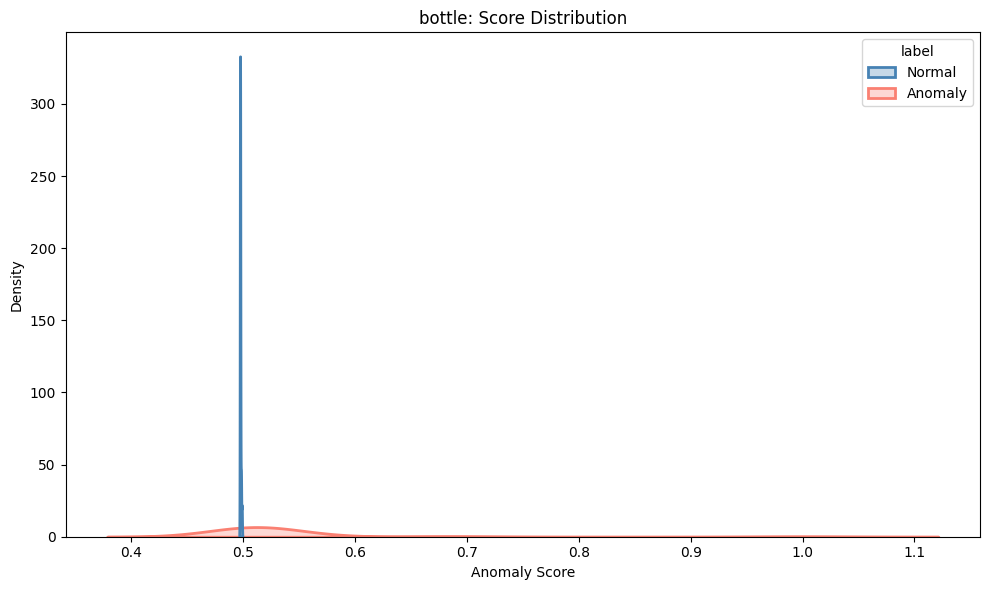

<Axes: title={'center': 'bottle: Score Distribution'}, xlabel='Anomaly Score', ylabel='Density'>

In [17]:
import numpy as np
import pandas as pd
from src.visual.plot import kde_plot

# 테스트할 카테고리 선택
target_category = 'bottle'
predictions = all_predictions[target_category]

y_true_list = []
y_score_list = []

for batch in predictions:
    # 텐서를 꺼내서 넘파이로 바꾸고 1차원으로 평탄화(.flatten())
    # 이렇게 하면 [[0.1], [0.2]] 가 [0.1, 0.2] 로 바뀝니다.
    scores = batch.pred_score.cpu().numpy().flatten()
    labels = batch.gt_label.cpu().numpy().flatten()

    y_score_list.append(scores)
    y_true_list.append(labels)

# 리스트를 합쳐서 최종 1차원 넘파이 배열 생성
y_score = np.concatenate(y_score_list)
y_true = np.concatenate(y_true_list)

# 데이터 분리 (정상=0, 이상=1)
normal_scores = y_score[y_true == 0]
anomaly_scores = y_score[y_true == 1]

# DataFrame 생성 (이제 에러가 나지 않습니다)
scores_df = pd.DataFrame({
    'score': np.concatenate([normal_scores, anomaly_scores]),
    'label': ['Normal'] * len(normal_scores) + ['Anomaly'] * len(anomaly_scores)
})

# 플롯 실행
kde_plot(
    scores_df,
    col='score',
    hue='label',
    palette=['steelblue', 'salmon'],
    title=f'{target_category}: Score Distribution',
    xlabel='Anomaly Score'
)

In [18]:
import torch
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    jaccard_score  # IoU
)

results = []
for category, preds in all_predictions.items():
    # Image-level
    y_true = np.concatenate([p.gt_label.cpu().numpy() for p in preds])
    y_score = np.concatenate([p.pred_score.cpu().numpy() for p in preds])
    y_pred = (y_score >= 0.5).astype(int)

    # Pixel-level
    gt_masks = torch.cat([p.gt_mask for p in preds]).int()
    pred_masks = torch.cat([(p.anomaly_map > 0.5).int() for p in preds])

    metrics = {
        "Category": category,
        "AUROC": round(roc_auc_score(y_true, y_score), 4),
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 4),
        "Dice": round(
            f1_score(
                gt_masks.flatten().cpu().numpy(),
                pred_masks.flatten().cpu().numpy(),
                zero_division=0
            ),
            4
        ),
        "IoU": round(
            jaccard_score(
                gt_masks.flatten().numpy(),
                pred_masks.flatten().numpy(),
                average='binary',
                zero_division=0
            ),
            4
        ),
        "N_samples": len(y_true)
    }
    results.append(metrics)

metrics_df = pd.DataFrame(results).set_index("Category")
avg_row = metrics_df.drop(columns=['N_samples']).mean().round(4)
avg_row['N_samples'] = metrics_df['N_samples'].sum()
metrics_df.loc['Average'] = avg_row

metrics_df

,AUROC,Accuracy,Precision,Recall,F1,Dice,IoU,N_samples
Category,,,,,,,,
bottle,1.0000,1.0000,1.0000,1.0000,1.0000,0.7771,0.6354,83.0
grid,0.9975,0.9872,1.0000,0.9825,0.9912,0.5179,0.3494,78.0
pill,0.9697,0.9521,0.9650,0.9787,0.9718,0.6818,0.5172,167.0
toothbrush,0.9056,0.8810,0.8788,0.9667,0.9206,0.3964,0.2472,42.0
Average,0.9682,0.9551,0.9610,0.9820,0.9709,0.5933,0.4373,370.0


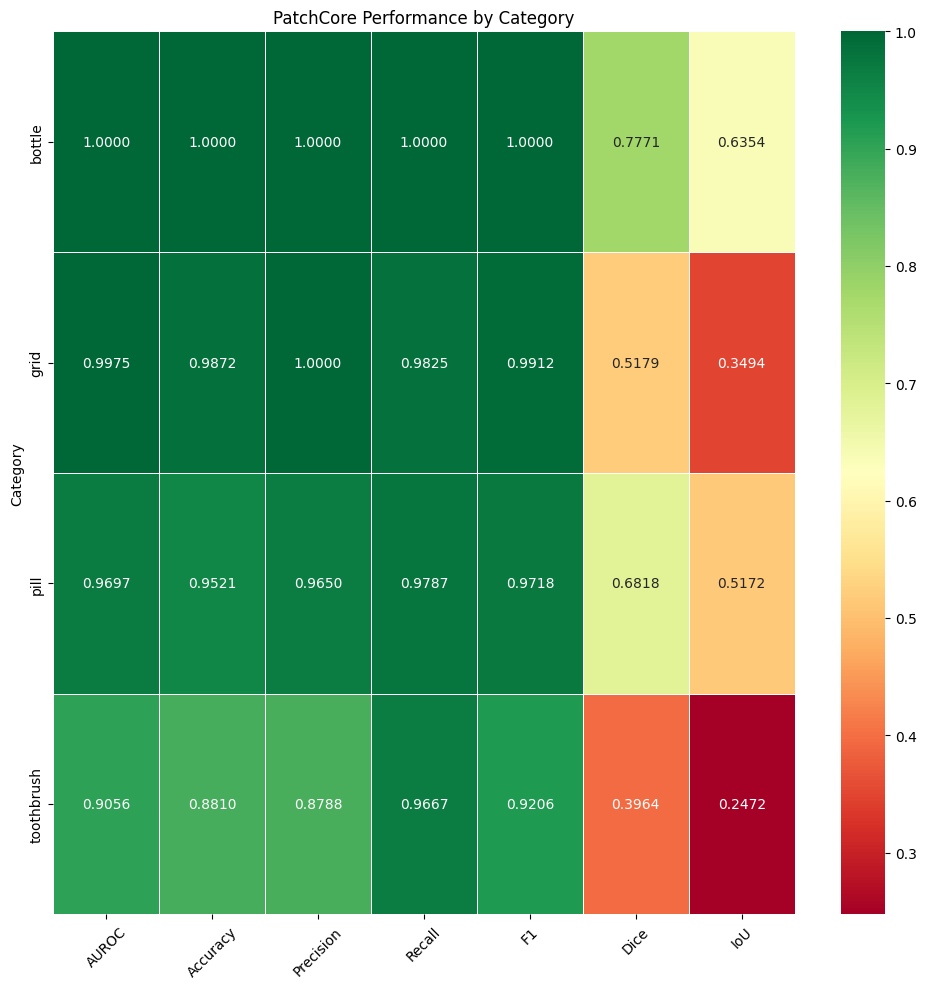

<Axes: title={'center': 'PatchCore Performance by Category'}, ylabel='Category'>

In [19]:
from src.visual.plot import heatmap_plot

metrics_trans = metrics_df.drop('Average').drop(columns='N_samples')
heatmap_plot(
    metrics_trans,
    figsize=(10, 10),
    cmap='RdYlGn',
    annot=True,
    fmt='.4f',
    linewidths=0.5,
    title='PatchCore Performance by Category',
    rotation_x=45,
    rotation_y=0
)

In [20]:
from src.visual.plot import anomaly_grid_from_dir

for category in categories:
    OUTPUT_IMG_ROOT = OUTPUT_ROOT / "Patchcore" / "MVTecAD" / category / "latest" / "images"
    print(f"{category}")
    anomaly_grid_from_dir(OUTPUT_IMG_ROOT, n_samples=1, n_cols=1)

bottle
No images found in /content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation/output/Patchcore/MVTecAD/bottle/latest/images
grid
No images found in /content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation/output/Patchcore/MVTecAD/grid/latest/images
pill
No images found in /content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation/output/Patchcore/MVTecAD/pill/latest/images
toothbrush
No images found in /content/drive/Othercomputers/my_notebook/lion_final_pro_multimodal-anomaly-report-generation/output/Patchcore/MVTecAD/toothbrush/latest/images
